# EDA, Classification of Residential Energy Appliance

Greenhouse gas emissions have become an increasingly concerning issue across the globe. They result in climate change, which in turn have far-reaching environmental and health consequences. Energy production and consumption is the main contributor to greenhouse gas emissions. Furthermore, empirical study shows that electricity consumption in residential areas contributes to more than 20% of this total energy consumption. 

In this project, I will be dealing with a time-series dataset. I will attempt to forecast the activation period for various appliances, all of which are commonly used in households in residential areas. This task can prove to be crucial because by using various machine learning techniques and correctly forecasting the activation period of appliances, we will have a better foresight of electricity consumption information, which in turn might provide valuable insights to come up with a better energy-saving technology. 

There are 2 main challenges that we need to address, when it comes to the dataset given. The first challenge is how to effectively tackle a time-series dataset. The second challenge is, there are severe class imbalance issues for most of the target variables. 

To tackle the first challenge, we employ a specific way of implementing cross validation, which we refer to as rolling fold cross validation. For the second challenge, we implement resampling to help alleviate the class imbalance issue. The resampling method that we used is undersampling, with additional modification to preserve the sequential structure of the data in a time-series dataset.

The aim is to develop multiple classifiers for each individual target appliance that can detect whether target appliances are being used in each time interval as correctly as possible. This means that I will develop 5 classifiers for 5 appliances. 
 
## Table of Content
1. [Exploratory Data Analysis](#1)
2. [Model Development](#2)
3. [Prediction Task](#3)
4. [Results and Discussion](#4)

In [2]:
#Load libraries
library(psych)
library(ggplot2)
library(reshape2)
library(GGally)
library(tidyverse)
library(dplyr)
library(data.table)
library(randomForest)
library(caret)
library(glmnet)

## 1. Exploratory Data Analysis <a class="anchor" id="1"></a>

In [4]:
#Load training and testing data
train.data<-read.csv('train.csv')
test.data<-read.csv('test.csv')
head(train.data)
head(test.data)

X,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst
105541,2.245,0,0,0,0,0,0,Sun,0.987,0.987,6.215,3.074549,0.6788858,0.05290291,0.9940715
105542,2.259,0,0,0,0,0,0,Sun,0.014,0.014,6.215,3.172867,0.6674503,0.05482926,0.9941540
105543,2.269,0,0,0,0,0,0,Sun,0.010,0.010,6.215,3.270112,0.6477770,0.05699074,0.9942200
105544,2.268,0,0,0,0,0,0,Sun,-0.001,0.001,6.215,3.303763,0.6292270,0.05760593,0.9941497
105545,2.270,0,0,0,0,0,0,Sun,0.002,0.002,6.215,3.302744,0.6212951,0.08263997,0.9940406
105546,2.259,0,0,0,0,0,0,Sun,-0.011,0.011,6.215,3.298258,0.6269564,0.08978753,0.9939864


X,load,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst
1,1.869,0,Mon,0.000,0.000,0,0,0,0,0
2,1.673,0,Mon,-0.196,0.196,0,0,0,0,0
3,1.660,0,Mon,-0.013,0.013,0,0,0,0,0
4,1.772,0,Mon,0.112,0.112,0,0,0,0,0
5,1.679,0,Mon,-0.093,0.093,0,0,0,0,0
6,1.775,0,Mon,0.096,0.096,0,0,0,0,0


In [5]:
#Convert to target variables to factor
train.data[,'ac']<-factor(train.data[,'ac'])
train.data[,'ev']<-factor(train.data[,'ev'])
train.data[,'oven']<-factor(train.data[,'oven'])
train.data[,'wash']<-factor(train.data[,'wash'])
train.data[,'dryer']<-factor(train.data[,'dryer'])
str(train.data)

'data.frame':	417720 obs. of  16 variables:
 $ X        : int  105541 105542 105543 105544 105545 105546 105547 105548 105549 105550 ...
 $ load     : num  2.25 2.26 2.27 2.27 2.27 ...
 $ ac       : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ ev       : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ oven     : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ wash     : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ dryer    : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ hourofday: int  0 0 0 0 0 0 0 0 0 0 ...
 $ dayofweek: Factor w/ 7 levels "Fri","Mon","Sat",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ dif      : num  0.987 0.014 0.01 -0.001 0.002 ...
 $ absdif   : num  0.987 0.014 0.01 0.001 0.002 ...
 $ max      : num  6.21 6.21 6.21 6.21 6.21 ...
 $ var      : num  3.07 3.17 3.27 3.3 3.3 ...
 $ entropy  : num  0.679 0.667 0.648 0.629 0.621 ...
 $ nonlinear: num  0.0529 0.0548 0.057 0.0576 0.0826 ...
 $ hurst    : num  0.994 0.994 0.994 0.994 0.994 ...


In [6]:
summary(train.data)

       X               load        ac         ev         oven       wash      
 Min.   :105541   Min.   : 0.298   0:316521   0:415385   0:411764   0:409767  
 1st Qu.:209971   1st Qu.: 0.807   1:101199   1:  2335   1:  5956   1:  7953  
 Median :314401   Median : 1.279                                              
 Mean   :314401   Mean   : 2.185                                              
 3rd Qu.:418830   3rd Qu.: 3.358                                              
 Max.   :523260   Max.   :11.794                                              
                                                                              
 dryer        hourofday     dayofweek        dif                absdif      
 0:404144   Min.   : 0.00   Fri:58260   Min.   :-7.970000   Min.   :0.0000  
 1: 13576   1st Qu.: 5.00   Mon:61440   1st Qu.:-0.011000   1st Qu.:0.0020  
            Median :11.00   Sat:58080   Median :-0.001000   Median :0.0100  
            Mean   :11.48   Sun:59940   Mean   :-0.000001   

- `load` seems to be a bit right-skwewed. This makes sense as there cannot be negative value of load. On the other hand, for very rare occasions where multiple appliances are activated, the value of load will be very high, but this is not the common case. 

- `entropy` has IQR from 0.64 to 0.74. `entropy` measures the “forecastability” of a time series, where low values indicate a high signal-to-noise ratio, and large values occur when a series is difficult to forecast. It seems like what we have here mostly fall into the medium range.

- There is an extremely **severe class imbalance** for some target variables, especially `ev` , `oven` , `wash` and `dryer` 

In [7]:
describe(train.data)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X,1,417720,3.144005e+05,1.205855e+05,3.144005e+05,3.144005e+05,1.548279e+05,105541.000,5.232600e+05,4.177190e+05,-1.716869e-17,-1.20000862,1.865746e+02
load,2,417720,2.184664e+00,1.890565e+00,1.279000e+00,1.918025e+00,8.421168e-01,0.298,1.179400e+01,1.149600e+01,1.134783e+00,-0.07882485,2.925155e-03
ac*,3,417720,1.242265e+00,4.284544e-01,1.000000e+00,1.177831e+00,0.000000e+00,1.000,2.000000e+00,1.000000e+00,1.203088e+00,-0.55258008,6.629213e-04
ev*,4,417720,1.005590e+00,7.455626e-02,1.000000e+00,1.000000e+00,0.000000e+00,1.000,2.000000e+00,1.000000e+00,1.326271e+01,173.89984926,1.153563e-04
oven*,5,417720,1.014258e+00,1.185542e-01,1.000000e+00,1.000000e+00,0.000000e+00,1.000,2.000000e+00,1.000000e+00,8.194407e+00,65.14845664,1.834316e-04
wash*,6,417720,1.019039e+00,1.366625e-01,1.000000e+00,1.000000e+00,0.000000e+00,1.000,2.000000e+00,1.000000e+00,7.038652e+00,47.54274261,2.114495e-04
dryer*,7,417720,1.032500e+00,1.773247e-01,1.000000e+00,1.000000e+00,0.000000e+00,1.000,2.000000e+00,1.000000e+00,5.272798e+00,25.80245821,2.743637e-04
hourofday,8,417720,1.148449e+01,6.920358e+00,1.100000e+01,1.148133e+01,8.895600e+00,0.000,2.300000e+01,2.300000e+01,3.070053e-03,-1.20380632,1.070745e-02
dayofweek*,9,417720,4.013646e+00,2.001499e+00,4.000000e+00,4.017057e+00,2.965200e+00,1.000,7.000000e+00,6.000000e+00,-4.563216e-03,-1.25694088,3.096798e-03
dif,10,417720,-7.038207e-07,5.309284e-01,-1.000000e-03,-2.249922e-03,1.482600e-02,-7.970,7.619000e+00,1.558900e+01,1.270821e+00,26.83443496,8.214731e-04


There are no missing values. Next, we explore the boxplots to examine their distribution

Warning message in melt(as.data.frame(train.data[-c(1, 3, 4, 5, 6, 7, 9)])):
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(as.data.frame(train.data[-c(1, 3, 4, 5, 6, 7, 9)])). In the next version, this warning will become an error."No id variables; using all as measure variables


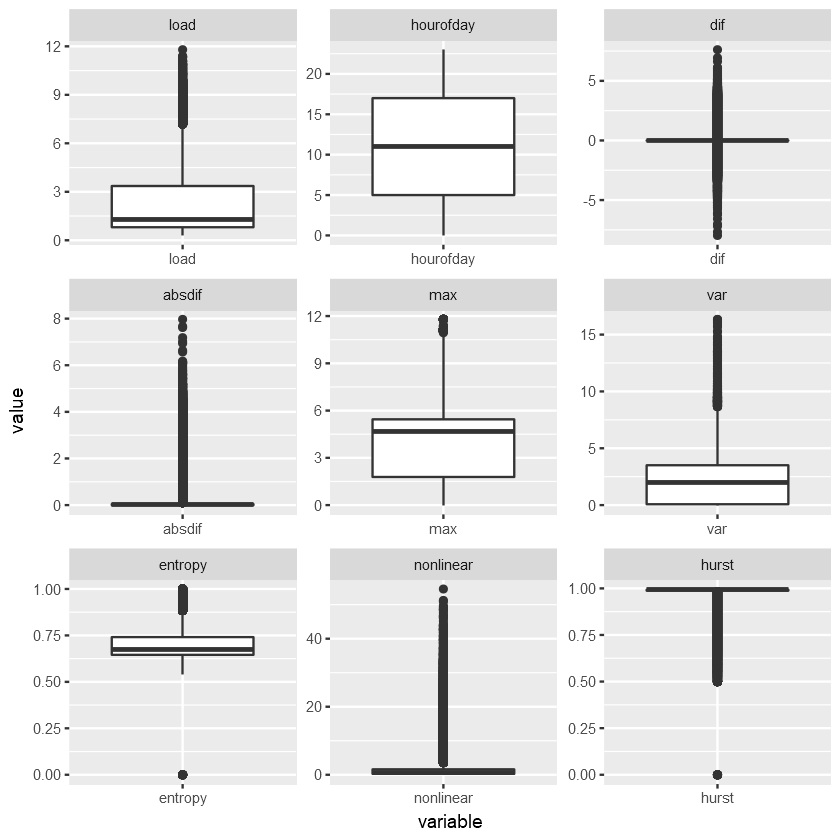

In [8]:
train.box<-melt(as.data.frame(train.data[-c(1,3,4,5,6,7,9)]))
ggplot(train.box,aes(x=variable,y=value))+
    facet_wrap(~variable,scales='free')+
    geom_boxplot()

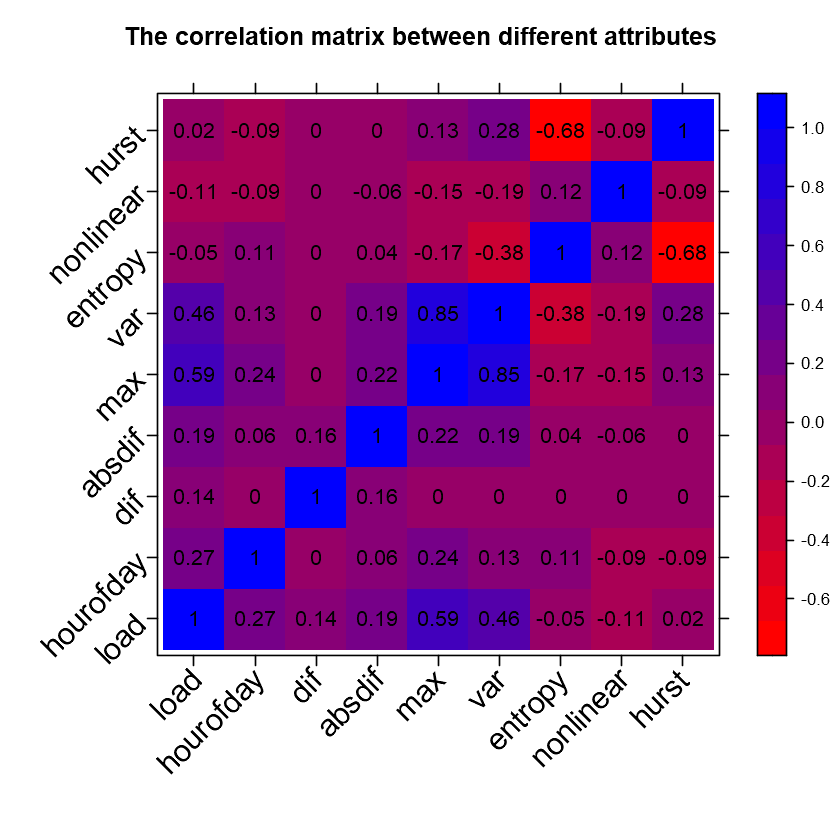

In [9]:
options(repr.plot.width=7, repr.plot.height=7)

# function  of the text of the correlation plot
paneltext <-function(x, y, z, ...) {
    panel.levelplot(x,y,z,...)
    panel.text(x,y,round(z, 2))
}
#Define the color scheme
cols = colorRampPalette(c("red","blue"))
#Plot the correlation matrix.
levelplot(cor(train.data[-c(1,3,4,5,6,7,9)]), col.regions = cols(100), main = "The correlation matrix between different attributes", 
          xlab = NULL, ylab = NULL, 
scales = list(x = list(rot = 45,cex=1.5),y = list(rot = 45,cex=1.5)),panel = paneltext)

- There is a strong positive linear correlation between `var` and `max`

- There is a weak negative linear correlation between `hurst` and `entropy`. As `hurst` increases (greater long-term memory), `entropy` decreases(low value of entropy indicates a high signal-to-noise ratio ->easier to forecast). This makes because increase in `hurst` means a greater long-term memory of a time series, which is consistent with a decrease in `entropy`, which means a higher signal-to-noise ratio, hence makes it easier to forecast.

These correlation will be taken into account when we build randomForest classifier, as randomForest builds trees that have rule-like pattern, hence they implicitly consider variable interaction as well.

In [10]:
train.data[5356:5360,]  #row 5358
train.data[139459:139463,]  #row 139461

,X,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst
5356,110896,5.319,1,0,0,0,0,17,Wed,0.583,0.583,9.354,9.079162,0.6647435,0.10206690,0.9912188
5357,110897,5.342,1,0,0,0,0,17,Wed,0.023,0.023,9.354,9.207715,0.6651521,0.11780220,0.9908669
5358,110898,1.755,0,0,0,0,0,2,Fri,-3.587,3.587,9.354,9.370639,0.6642243,0.08193567,0.9909383
5359,110899,5.315,1,0,0,0,0,17,Wed,3.560,3.560,9.354,9.531306,0.6619385,0.07256142,0.9910337
5360,110900,5.336,1,0,0,0,0,17,Wed,0.021,0.021,9.354,9.692591,0.6593139,0.06454659,0.9911243


,X,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst
139459,244999,8.777,1,0,1,0,0,9,Sat,0.003,0.003,8.8,9.107085,0.7650282,0.10483612,0.9801537
139460,245000,8.772,1,0,1,0,0,9,Sat,-0.005,0.005,8.8,9.123997,0.7725285,0.09801500,0.9807521
139461,245001,0.802,0,0,0,0,0,9,Tue,-7.970,7.970,8.8,9.085604,0.7741791,0.09771141,0.9810216
139462,245002,7.434,1,0,1,0,0,9,Sat,6.632,6.632,8.8,9.026540,0.7697209,0.09851416,0.9811455
139463,245003,4.821,1,0,0,0,0,9,Sat,-2.613,2.613,8.8,8.959326,0.7631386,0.10014973,0.9811997


As we can see, row with index 5358 is totally out of place, regarding its values of `hourofday` and `dayofweek` as compared to rows preceding it and succeeding it. Likewise, row with index 139461 has the wrong value of `dayofweek`. We will filter out these incorrect rows.

In [11]:
#incorrect rows for hourofday
#where hourofday is not the same as both the row directly above it and the row directly below it
incor.hour<-filter(train.data,
       (lag(train.data$hourofday)!=train.data$hourofday & lead(train.data$hourofday)!=train.data$hourofday))

#incorrect rows for dayofweek
#where dayofweek is not the same as both the row directly above it and the row directly below it
incor.day<-filter(train.data,
       lag(train.data$dayofweek)!=train.data$dayofweek & lead(train.data$dayofweek)!=train.data$dayofweek)

In [12]:
#need to filter out these rows from train.data
train.data<-train.data[!train.data$X %in% incor.hour$X,]
train.data<-train.data[!train.data$X %in% incor.day$X,]

In [13]:
#reset row index for convenience
row.names(train.data) <- NULL

In [14]:
#After remove incorrect rows, need to recalculate dif and absdif
train.data[,'dif']<-train.data$load-lag(train.data$load,1,na.pad=TRUE)
train.data[,'absdif']<-abs(train.data$dif)

### Feature Engineering

For feature engineering, i will generate several new features. 
- `minuteofhour` variable is the minute within each hour, derived from `hourofday` variable. 
- `minuteofday` variable is the minute within each day, derived from `dayofweek` variable.
- `difflag` variables are the difference between the value of `load` and its corresponding lag. For example, `difflag10` variable is the difference between the value of `load` and the 10th lag of value of `load`. However, it is not efficient to generate random `difflag` variables. In order to know what kind of `difflag` would be most appropriate for each target variable, we need to consider their activation window. Since appliances usage last for a while, this activation window can prove to be insightful and help us decide what values of `difflag` to consider. Thefore, we need to narrow down what would be the optimal activation window sizes. One way to do this is to consider the most frequently-occurred activation window sizes.
- We need to pad the NaN values created due to the generation of `difflag` variables in the test set. I simply impute these NaN values as 0 in the test set.

#### Generate `minuteofhour` and `minuteofday` variables

In [15]:
#Create minuteofhr that increments on the difference of hourofday
train.data$minuteofhr <- cumsum(c(0,as.numeric(diff(train.data$hourofday))!=0))

#Convert to data table form 
train.data=data.table(train.data)
N<-nrow(train.data)

#Create minuteofhour that increments by the same value of minuteofhr, reset for new value of minuteofhr
train.data[,minuteofhour:=1:.N,by=minuteofhr]

#convert back to data frame
train.data=data.frame(train.data)

#There are some strange values of minuteofhour (>60)
train.data[train.data$minuteofhour>60,]

,X,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst,minuteofhr,minuteofhour
27403,132949,4.891,1,0,0,0,1,0,Fri,0.109,0.109,4.956,2.6361546721,0.6392512,0.03148504,0.9935212,471,61
27404,132950,4.779,1,0,0,0,1,0,Fri,-0.112,0.112,4.956,2.6471973235,0.6326943,0.02292327,0.9935300,471,62
27405,132951,4.777,1,0,0,0,1,0,Fri,-0.002,0.002,4.956,2.6557939115,0.6347873,0.02068625,0.9935320,471,63
27406,132952,3.071,1,0,0,0,1,0,Fri,-1.706,1.706,4.956,2.6645122721,0.6433018,0.01837958,0.9935329,471,64
27407,132953,1.602,0,0,0,0,0,0,Fri,-1.469,1.469,4.956,2.6729411792,0.6518286,0.01699347,0.9935326,471,65
27408,132954,0.993,0,0,0,0,0,0,Fri,-0.609,0.609,4.956,2.6812962885,0.6544906,0.02038191,0.9935344,471,66
27409,132955,0.618,0,0,0,0,0,0,Fri,-0.375,0.375,4.956,2.6923427727,0.6496374,0.01187911,0.9935394,471,67
27410,132956,0.635,0,0,0,0,0,0,Fri,0.017,0.017,4.956,2.7009262825,0.6409704,0.01027663,0.9935360,471,68
27411,132957,0.679,0,0,0,0,0,0,Fri,0.044,0.044,4.956,2.7674791858,0.6351432,0.09564141,0.9913762,471,69
27412,132958,0.697,0,0,0,0,0,0,Fri,0.018,0.018,4.956,2.8898610874,0.6381889,0.21488418,0.9914636,471,70


In [16]:
#Subtract these values of minuteofhour by 60, to get a valid value of minuteofhour
train.data$minuteofhour<-ifelse(train.data$minuteofhour>60,train.data$minuteofhour-60,train.data$minuteofhour)
train.data<-train.data[,-17]

In [17]:
#Create minofday that increments on the difference of dayofweek
train.data$minofday <- cumsum(c(0,as.numeric(diff(train.data$dayofweek))!=0))

#Convert to data table form 
train.data=data.table(train.data)
N<-nrow(train.data)

#Create minuteofday that increments by the same value of minofday, reset for new value of minofday
train.data[,minuteofday:=1:.N,by=minofday]

#convert back to data frame
train.data=data.frame(train.data)

#Once again, there are some strange values of minuteofday (>1440)
train.data[train.data$minuteofday>1440,]

,X,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst,minuteofhour,minofday,minuteofday
248020,353835,0.751,0,0,0,0,0,23,Thu,-0.092,0.092,1.076,0.034173646,0.5591225,0.73548259,0.9960161,15,258,1441
248021,353836,0.757,0,0,0,0,0,23,Thu,0.006,0.006,1.076,0.034843090,0.5531365,0.77056438,0.9963005,16,258,1442
248022,353837,0.740,0,0,0,0,0,23,Thu,-0.017,0.017,1.076,0.034956478,0.5480139,0.75319765,0.9963821,17,258,1443
248023,353838,0.744,0,0,0,0,0,23,Thu,0.004,0.004,1.049,0.034220032,0.5466768,0.70911576,0.9963915,18,258,1444
248024,353839,0.690,0,0,0,0,0,23,Thu,-0.054,0.054,1.041,0.033616394,0.5500914,0.69805031,0.9963955,19,258,1445
248025,353840,0.633,0,0,0,0,0,23,Thu,-0.057,0.057,1.041,0.033212486,0.5555042,0.62188972,0.9963877,20,258,1446
248026,353841,0.612,0,0,0,0,0,23,Thu,-0.021,0.021,1.041,0.032984551,0.5595246,0.47526666,0.9963723,21,258,1447
248027,353842,0.589,0,0,0,0,0,23,Thu,-0.023,0.023,1.041,0.032759123,0.5605104,0.41066859,0.9963636,22,258,1448
248028,353843,0.616,0,0,0,0,0,23,Thu,0.027,0.027,1.041,0.032369401,0.5579804,0.38324600,0.9963589,23,258,1449
248029,353844,0.631,0,0,0,0,0,23,Thu,0.015,0.015,1.041,0.032031005,0.5532167,0.30041561,0.9963451,24,258,1450


In [18]:
#Subtract these values of minuteofday by 1440, to get a valid value of minuteofday
train.data$minuteofday<-ifelse(train.data$minuteofday>1440,train.data$minuteofday-1440,train.data$minuteofday)
train.data<-train.data[,-18]

Also create `minuteofhour` and `minuteofday` for test data

In [19]:
test.dat<-test.data
#Create minuteofhour
test.dat$minuteofhr <- cumsum(c(0,as.numeric(diff(test.dat$hourofday))!=0))
test.dat=data.table(test.dat)
N<-nrow(test.dat)
test.dat[,minuteofhour:=1:.N,by=minuteofhr]
test.dat=data.frame(test.dat)
test.dat<-test.dat[,-12]

#Create minuteofday
test.dat$minofday <- cumsum(c(0,as.numeric(diff(test.dat$dayofweek))!=0))
test.dat=data.table(test.dat)
N<-nrow(test.dat)
test.dat[,minuteofday:=1:.N,by=minofday]
test.dat=data.frame(test.dat)
test.dat<-test.dat[,-13]
head(test.dat)

X,load,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst,minuteofhour,minuteofday
1,1.869,0,Mon,0.000,0.000,0,0,0,0,0,1,1
2,1.673,0,Mon,-0.196,0.196,0,0,0,0,0,2,2
3,1.660,0,Mon,-0.013,0.013,0,0,0,0,0,3,3
4,1.772,0,Mon,0.112,0.112,0,0,0,0,0,4,4
5,1.679,0,Mon,-0.093,0.093,0,0,0,0,0,5,5
6,1.775,0,Mon,0.096,0.096,0,0,0,0,0,6,6


#### Generate `difflag` variables for `ac`

In [20]:
ac.data<-train.data

#Extract only target column ac
ac.data<-ac.data %>% select(-(4:7))

##Create ac_grp that increments on the difference of ac
ac.data$ac_grp <- cumsum(c(0,as.numeric(diff(ac.data$ac))!=0))

#Get the data where ac=1
ac.data.1<-ac.data[ac.data$ac==1,]

#Get the count of ac_grp, hence obtain all the values of activation window for ac
ac.window.size<-ac.data.1 %>% count(ac_grp)
summary(ac.window.size$n)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   15.00   17.00   21.44   23.00  585.00 

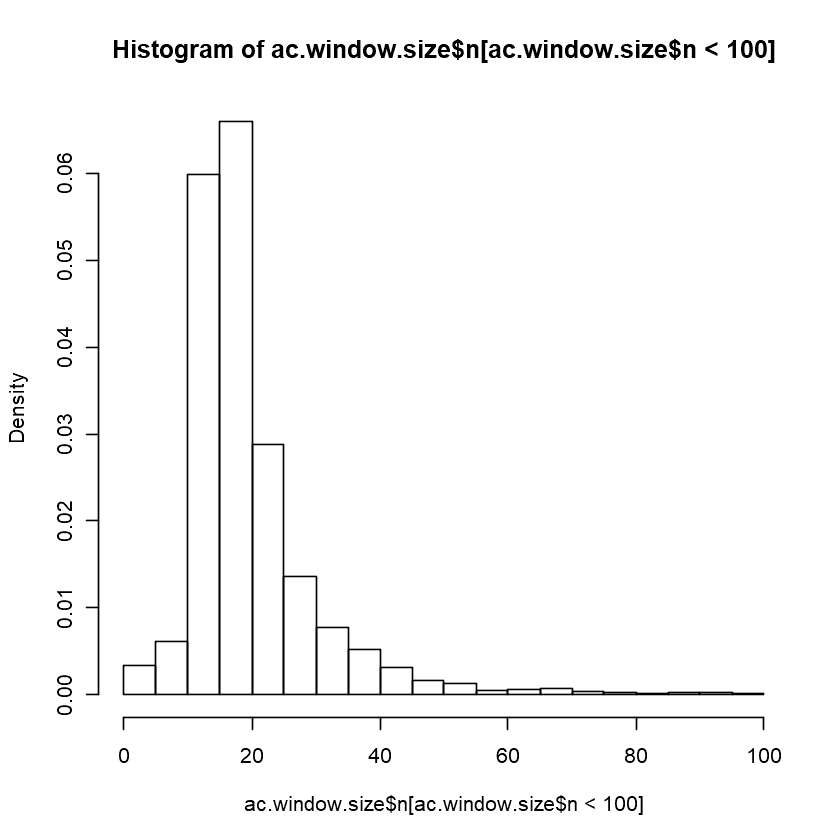

In [21]:
#plot a histogram for activation window of ac
hist(ac.window.size$n[ac.window.size$n<100],freq=FALSE)

In [22]:
#activation window for ac seems to be predominantly around 10 to 30
#Hence, create difference with lag 10 to lag 30
for (i in 10:30){
    ac.data[,paste0('difflag',i)]<-ac.data$load-lag(ac.data$load,i,na.pad=TRUE)
}
ac.data<-ac.data[-15]

#Also generate the same difflag variables for ac test data
ac.test<-test.dat
for (i in 10:30){
    ac.test[,paste0('difflag',i)]<-ac.test$load-lag(ac.test$load,i,na.pad=TRUE)
}

#### Generate `difflag` variables for `ev`

In [23]:
ev.data<-train.data

#Extract only target column ev
ev.data<-ev.data %>% select(-c(3,5,6,7))

#Create ev_grp that increments on the difference of ac
ev.data$ev_grp <- cumsum(c(0,as.numeric(diff(ev.data$ev))!=0))

#Get the data where ev=1
ev.data.1<-ev.data[ev.data$ev==1,]

#Get the count of ev_grp, hence obtain all the values of activation window for ev
ev.window.size<-ev.data.1 %>% count(ev_grp)
summary(ev.window.size$n)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00    9.00   18.00   80.52  157.00  239.00 

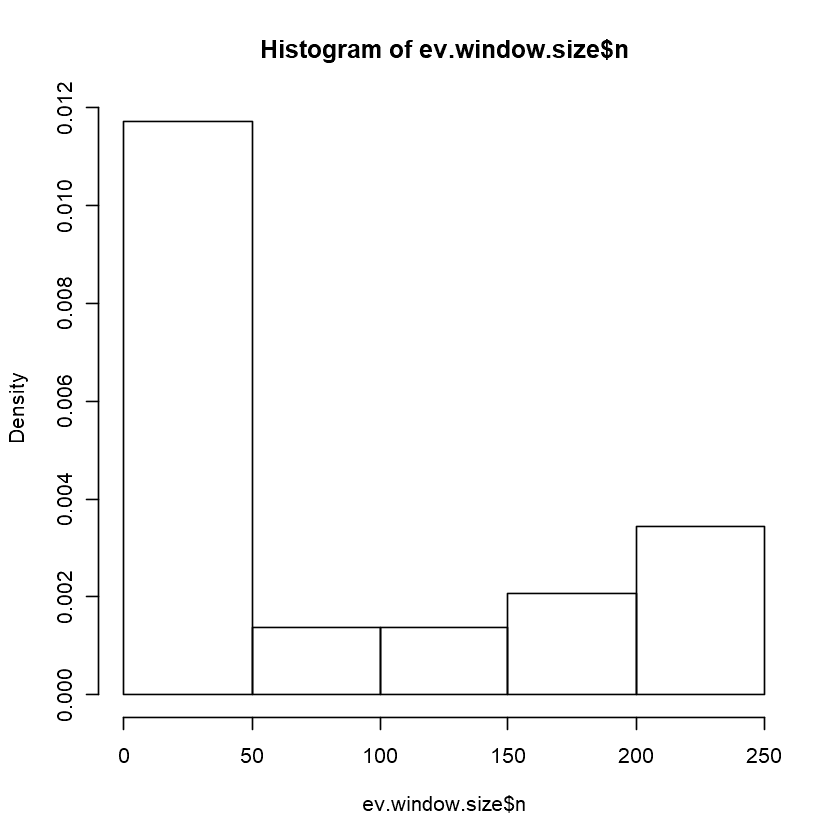

In [24]:
# hist(ac.window.size$n[ac.window.size$n<100],freq=FALSE)
hist(ev.window.size$n,freq=FALSE)

In [25]:
#activation window for ev are much more spread out compared to ac, so we consider a wider range of values 
ev.lag<-c(10, 12, 14, 16, 18, 20, 50, 100, 120, 140, 160, 180, 200, 220, 240)
for (i in ev.lag){
    ev.data[,paste0('difflag',i)]<-ev.data$load-lag(ev.data$load,i,na.pad=TRUE)
}
ev.data<-ev.data[-15]

#Also generate the same difflag variables for ev test data
ev.test<-test.dat
for (i in ev.lag){
    ev.test[,paste0('difflag',i)]<-ev.test$load-lag(ev.test$load,i,na.pad=TRUE)
}

#### Generate `difflag` variables for `oven`

In [26]:
oven.data<-train.data

#Extract only target column oven
oven.data<-oven.data %>% select(-c(3,4,6,7))

##Create oven_grp that increments on the difference of oven
oven.data$oven_grp <- cumsum(c(0,as.numeric(diff(oven.data$oven))!=0))

#Get the data where oven=1
oven.data.1<-oven.data[oven.data$oven==1,]

#Get the count of oven_grp, hence obtain all the values of activation window for oven
oven.window.size<-oven.data.1 %>% count(oven_grp)
summary(oven.window.size$n)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   3.000   5.568   5.000 143.000 

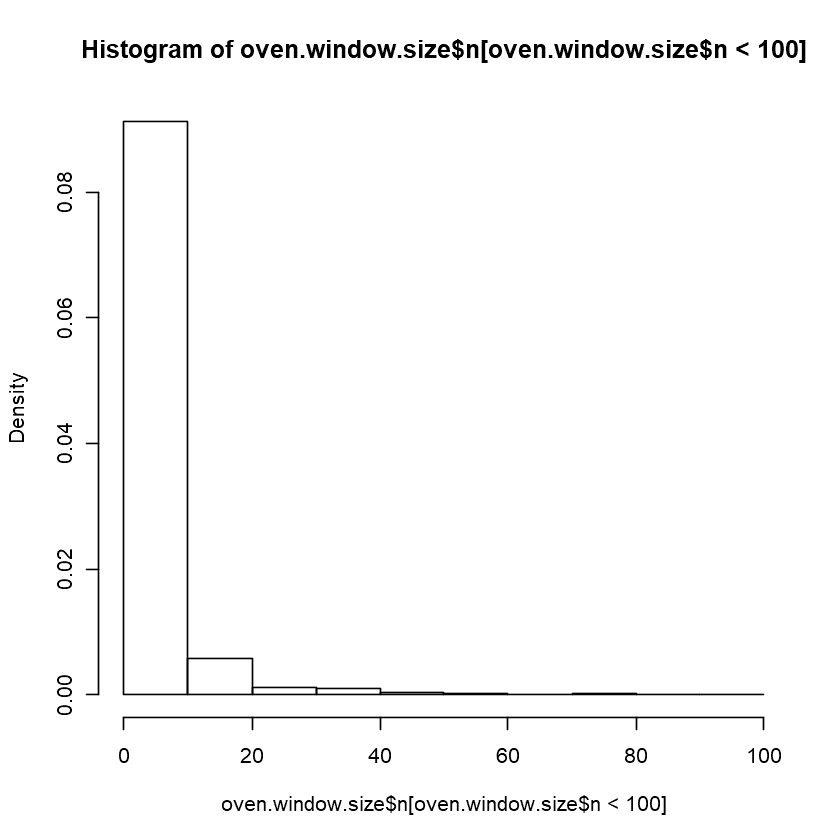

In [27]:
hist(oven.window.size$n[oven.window.size$n<100],freq=FALSE)

In [28]:
#activation window for oven is mainly around 1 to 20 
#Hence, create difference with lag 2 to lag 20
for (i in 2:20){
    oven.data[,paste0('difflag',i)]<-oven.data$load-lag(oven.data$load,i,na.pad=TRUE)
}
oven.data<-oven.data[-15]

#Also generate the same difflag variables for oven test data
oven.test<-test.dat
for (i in 2:20){
    oven.test[,paste0('difflag',i)]<-oven.test$load-lag(oven.test$load,i,na.pad=TRUE)
}

#### Generate `difflag` variables for `wash`

In [29]:
wash.data<-train.data

#Extract only target column wash
wash.data<-wash.data %>% select(-c(3,4,5,7))

##Create wash_grp that increments on the difference of wash
wash.data$wash_grp <- cumsum(c(0,as.numeric(diff(wash.data$wash))!=0))

#Get the data where wash=1
wash.data.1<-wash.data[wash.data$wash==1,]

#Get the count of wash_grp, hence obtain all the values of activation window for wash
wash.window.size<-wash.data.1 %>% count(wash_grp)
summary(wash.window.size$n)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   6.387   5.000 103.000 

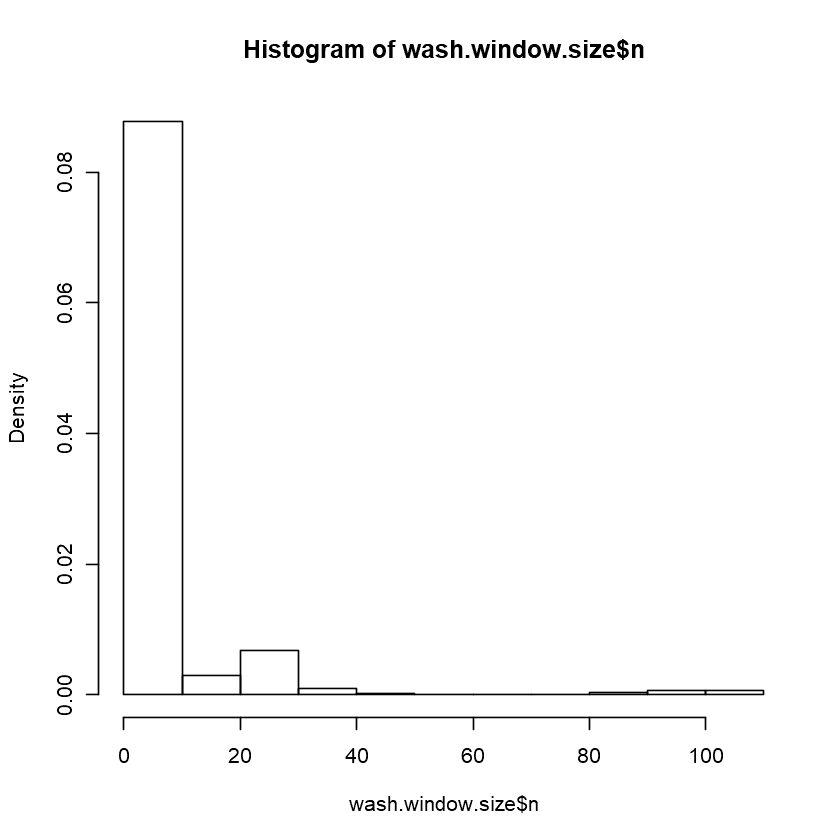

In [30]:
hist(wash.window.size$n,freq=FALSE)

In [31]:
#activation window for wash is mainly around 1 to 20 
#Hence, create difference with lag 2 to lag 20
for (i in 2:20){
    wash.data[,paste0('difflag',i)]<-wash.data$load-lag(wash.data$load,i,na.pad=TRUE)
}
wash.data<-wash.data[-15]

#Also generate the same difflag variables for wash test data
wash.test<-test.dat
for (i in 2:20){
    wash.test[,paste0('difflag',i)]<-wash.test$load-lag(wash.test$load,i,na.pad=TRUE)
}

#### Generate `difflag` variables for `dryer`

In [32]:
dryer.data<-train.data

#Extract only target column dryer
dryer.data<-dryer.data %>% select(-c(3,4,5,6))

##Create dryer_grp that increments on the difference of dryer
dryer.data$dryer_grp <- cumsum(c(0,as.numeric(diff(dryer.data$dryer))!=0))

##Get the data where dryer=1
dryer.data.1<-dryer.data[dryer.data$dryer==1,]

##Get the count of dryer_grp, hence obtain all the values of activation window for dryer
dryer.window.size<-dryer.data.1 %>% count(dryer_grp)
summary(dryer.window.size$n)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   45.00   87.00   88.09  135.00  177.00 

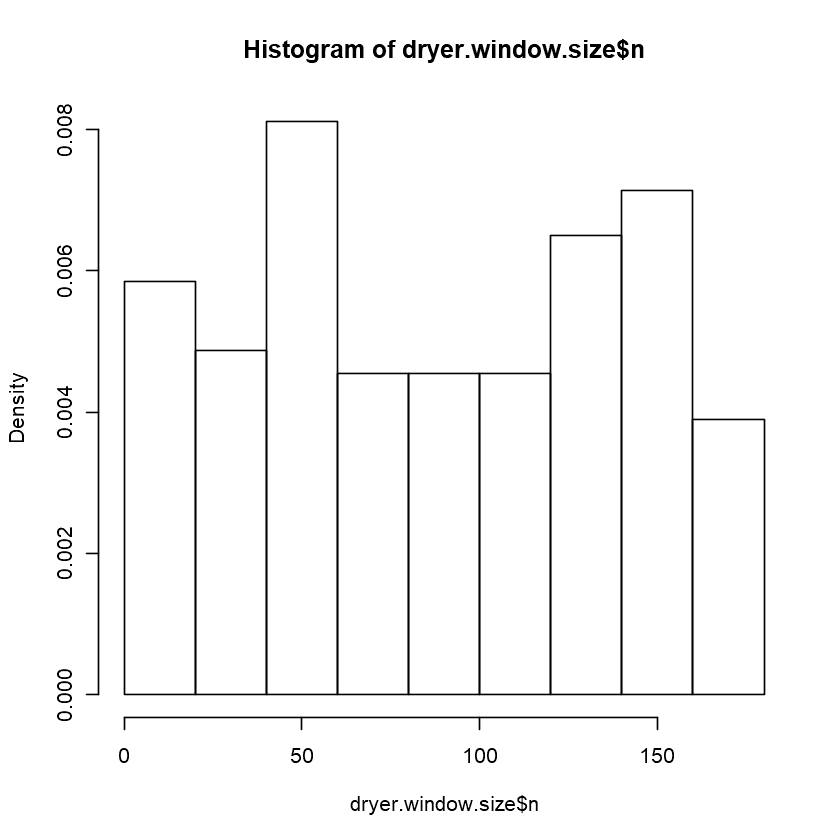

In [33]:
hist(dryer.window.size$n,freq=FALSE)

In [34]:
#Activation windows of dryer have no most commonly-occurred range, take on different range of values almost equally
#Hence, create difference with lag 20 to lag 180, step by 10
dryer.lag<-seq(20,180,10)
for (i in dryer.lag){
    dryer.data[,paste0('difflag',i)]<-dryer.data$load-lag(dryer.data$load,i,na.pad=TRUE)
}
dryer.data<-dryer.data[-15]

#Also generate the same difflag variables for dryer test data
dryer.test<-test.dat
for (i in dryer.lag){
    dryer.test[,paste0('difflag',i)]<-dryer.test$load-lag(dryer.test$load,i,na.pad=TRUE)
}

Since there are severe class imbalance issue in this data, we will make use of `f1 score` as the evaluation metrics. Now, we define a function to help us get f1 score from the actual true label and the prediction

In [35]:
f1<-function(truth,predict){
    conf.mat<-table(truth,predict)
    precision<-(conf.mat[2,2])/(conf.mat[2,2]+conf.mat[1,2])
    recall<-(conf.mat[2,2])/(conf.mat[2,2]+conf.mat[2,1])
    #handle zero division
    f1_score<-ifelse(conf.mat[2,2]==0,0,2*(precision*recall)/(precision+recall))
    return (f1_score)
}

## 2. Model Development <a class="anchor" id="2"></a>

### Build classifier for `ac`

In [36]:
table(ac.data$ac)


     0      1 
316267 101103 

There is no severe class imbalance issue for `ac`

In [37]:
#Get rid of X column
ac.data<-ac.data[-1]
#Get only rows where ac=1
ac.only<-ac.data[ac.data$ac==1,]
head(ac.only)

,load,ac,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,...,difflag21,difflag22,difflag23,difflag24,difflag25,difflag26,difflag27,difflag28,difflag29,difflag30
24,3.361,1,0,Sun,0.941,0.941,6.215,3.208320,0.6568986,0.3055014,...,1.092,1.102,1.116,NA,NA,NA,NA,NA,NA,NA
25,6.167,1,0,Sun,2.806,2.806,6.215,3.209429,0.6483738,0.3068348,...,3.899,3.898,3.908,3.922,NA,NA,NA,NA,NA,NA
26,6.204,1,0,Sun,0.037,0.037,6.215,3.210533,0.6323101,0.3064766,...,3.934,3.936,3.935,3.945,3.959,NA,NA,NA,NA,NA
27,6.215,1,0,Sun,0.011,0.011,6.215,3.211904,0.6157109,0.3029531,...,3.956,3.945,3.947,3.946,3.956,3.970,NA,NA,NA,NA
28,6.207,1,0,Sun,-0.008,0.008,6.215,3.210240,0.6082089,0.3023561,...,3.957,3.948,3.937,3.939,3.938,3.948,3.962,NA,NA,NA
29,6.199,1,0,Sun,-0.008,0.008,6.215,3.208092,0.6153455,0.3016025,...,3.948,3.949,3.940,3.929,3.931,3.930,3.940,3.954,NA,NA


In [38]:
#the last seen observation where ac=1 is row with index 256731
tail(ac.only)

,load,ac,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,...,difflag21,difflag22,difflag23,difflag24,difflag25,difflag26,difflag27,difflag28,difflag29,difflag30
256726,4.161,1,23,Wed,0.033,0.033,5.528,2.124582,0.6717405,0.6583473,...,3.203,3.201,3.206,3.192,3.193,3.191,3.198,3.197,3.211,3.211
256727,4.159,1,23,Wed,-0.002,0.002,5.528,2.136711,0.6752240,0.6627708,...,3.206,3.201,3.199,3.204,3.190,3.191,3.189,3.196,3.195,3.209
256728,4.125,1,23,Wed,-0.034,0.034,5.528,2.148734,0.6735393,0.6662568,...,3.171,3.172,3.167,3.165,3.170,3.156,3.157,3.155,3.162,3.161
256729,4.116,1,23,Wed,-0.009,0.009,5.528,2.160962,0.6689354,0.6729648,...,3.164,3.162,3.163,3.158,3.156,3.161,3.147,3.148,3.146,3.153
256730,4.116,1,23,Wed,0.000,0.000,5.528,2.172718,0.6635515,0.6778273,...,3.163,3.164,3.162,3.163,3.158,3.156,3.161,3.147,3.148,3.146
256731,3.965,1,23,Wed,-0.151,0.151,5.528,2.184972,0.6588178,0.6891294,...,3.020,3.012,3.013,3.011,3.012,3.007,3.005,3.010,2.996,2.997


In [39]:
dim(ac.data)
cat('The last',dim(ac.data)[1]-256731,'rows of ac.data have ac all equal to 0')

[1] 417370     34

The last 160639 rows of ac.data have ac all equal to 0

This is problematic because later on when we split the data into training and validation to do cross validation, if any validation split is within these 160639 rows, f1 score will be 0. So we train the classifier only on the first 300000 rows of `ac.data`

In [41]:
ac.sampling=ac.data[1:300000,]

We build a randomForest classfier to model `ac`

In [42]:
#train/valid split for time-series -> rolling basis
#split into 4 non-overlapping, equal-in-size folds
ac.split<-split(ac.sampling,(as.numeric(rownames(ac.sampling))-1) %/% floor(nrow(ac.sampling)/4+1))

#training folds
train.ac.f1<-ac.split$'0'
train.ac.f2<-rbind(train.ac.f1,ac.split$'1')
train.ac.f3<-rbind(train.ac.f2,ac.split$'2')

#validation folds
val.ac.f1<-ac.split$'1'
val.ac.f2<-ac.split$'2'
val.ac.f3<-ac.split$'3'

In [43]:
#cross validation to tune the number of tree
#For reproducibility
set.seed(1)

#Initialize an empty dataframe to store the tree and its resulting f1
ac.evaluation<-data.frame()

#No of trees to consider
no.tree<-seq(150,300,25)
counter<-1

#For each tree
for (j in no.tree){
    f1.j<-c()
    
    #perform 3-rolling-fold cross validation
    for (i in 1:3){
        
        #get the earlier fold as training fold
        train=eval(as.name(paste0('train.ac.f',i)))
        #get later fold as validation fold
        valid=eval(as.name(paste0('val.ac.f',i)))
        
        #train the randomforest for ac
        ac.rf=randomForest(ac~.,data=train,mtry=6,ntree=j,na.action=na.omit)
        
        #get the prediction on validation fold
        pred<-predict(ac.rf,newdata=valid)
        
        #compute f1
        f1.score<-f1(valid$ac,pred)
        f1.j<-c(f1.j,f1.score)
    }
    
    #get the average f1 for cross validation
    ac.f1<-sum(f1.j)/length(f1.j)
    
    #store values in dataframe
    ac.evaluation[counter,'no_tree']<-j
    ac.evaluation[counter,'f1_score']<-ac.f1
    counter<-counter+1
}

In [44]:
ac.evaluation

no_tree,f1_score
150,0.8954407
175,0.8925917
200,0.8893592
225,0.8906719
250,0.8943096
275,0.8907099
300,0.8913951


In [45]:
#Get the value of tree that results in the highest cross validated f1 score
ac.evaluation[ac.evaluation$f1_score==max(ac.evaluation$f1_score),]

no_tree,f1_score
150,0.8954407


In [46]:
#retrain the model on the whole ac.sampling data with the best value of tree
set.seed(1)
ac.rf<-randomForest(ac~.,data=ac.sampling,mtry=6,ntree=150,na.action=na.omit,importance=TRUE)

In [47]:
#get the prediction on the whole ac.data
rf.ac.pred<-predict(ac.rf,ac.data)

#compute confusion matrix
confusionMatrix(table(truth=ac.data$ac,predict=rf.ac.pred),positive='1') #perfect on training set

Confusion Matrix and Statistics

     predict
truth      0      1
    0 315489    755
    1      0 101096
                                          
               Accuracy : 0.9982          
                 95% CI : (0.9981, 0.9983)
    No Information Rate : 0.756           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9951          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9926          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9976          
             Prevalence : 0.2440          
         Detection Rate : 0.2422          
   Detection Prevalence : 0.2422          
      Balanced Accuracy : 0.9963          
                                          
       'Positive' Class : 1               
                                  

In [48]:
#Get f1 score
ac.f1<-f1(ac.data$ac,rf.ac.pred)
ac.f1

[1] 0.9962798

Using Random Forest, we manage to get a very high `f1 score`, predicting `ac`

###  Build classifier for `ev`

In [49]:
table(ev.data$ev) #severe class imbalance issue


     0      1 
415035   2335 

In [50]:
#Remove X column
ev.data<-ev.data[-1]

#Quite a number of features
colnames(ev.data)

[1] "load"         "ev"           "hourofday"    "dayofweek"    "dif"         
 [6] "absdif"       "max"          "var"          "entropy"      "nonlinear"   
[11] "hurst"        "minuteofhour" "minuteofday"  "difflag10"    "difflag12"   
[16] "difflag14"    "difflag16"    "difflag18"    "difflag20"    "difflag50"   
[21] "difflag100"   "difflag120"   "difflag140"   "difflag160"   "difflag180"  
[26] "difflag200"   "difflag220"   "difflag240"

In [51]:
#get the data where ev=1
ev.only=ev.data[ev.data$ev==1,]
ev.only

,load,ev,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,...,difflag20,difflag50,difflag100,difflag120,difflag140,difflag160,difflag180,difflag200,difflag220,difflag240
41431,8.314,1,18,Sun,2.614,2.614,9.285,2.781009,0.6375875,0.3256382,...,2.965,1.772,2.662,2.836,2.209,2.723,2.851,2.612,6.126,2.922
41432,8.923,1,18,Sun,0.609,0.609,9.285,2.763901,0.6290902,0.3137919,...,3.569,1.448,3.250,3.456,3.240,3.327,3.480,3.249,6.900,3.549
41433,8.825,1,18,Sun,-0.098,0.098,9.285,2.740749,0.6130937,0.3160131,...,3.480,1.591,3.173,3.390,3.136,3.256,3.377,3.136,7.617,3.433
41434,8.767,1,18,Sun,-0.058,0.058,9.285,2.711568,0.5991761,0.3196799,...,3.393,2.733,3.288,3.306,2.792,3.169,3.296,3.051,7.644,3.374
41435,8.773,1,18,Sun,0.006,0.006,9.285,3.296712,0.5982351,0.1595938,...,3.372,3.191,2.501,3.341,1.820,3.181,3.328,3.074,7.625,3.421
41436,8.729,1,18,Sun,-0.044,0.044,9.285,3.265573,0.6239193,4.2282557,...,3.340,3.144,2.202,3.263,3.042,3.244,3.351,3.118,7.550,3.354
41437,8.712,1,18,Sun,-0.017,0.017,9.285,3.226303,0.6794117,4.1929970,...,3.323,2.947,2.220,3.183,2.986,3.224,3.361,3.067,7.519,3.308
41438,8.720,1,18,Sun,0.008,0.008,9.285,3.180909,0.7502596,4.1500883,...,3.325,2.975,2.282,3.175,3.016,3.250,3.400,3.096,7.510,3.300
41439,8.726,1,18,Sun,0.006,0.006,9.285,3.127205,0.8145681,4.1047609,...,3.155,2.990,2.298,3.105,3.040,3.220,3.241,3.084,7.504,3.247
41440,8.761,1,18,Sun,0.035,0.035,9.285,3.068804,0.8591845,4.0546091,...,3.183,2.456,2.516,3.060,3.076,3.186,3.160,3.061,7.536,3.319


We build Random Forest classifier to model `ev`

In [52]:
#tuning the number of precede/succeed rows and tree that maximize f1 
bestrow<-data.frame()
row.counter<-1

#Consider a range of number of precede/succeed rows
row.sampling<-seq(150,300,10)
for (r in row.sampling){
    
    #Get the row index of rows that precedes the rows in ev.only by r rows
    ev.precede=as.character(as.numeric(rownames(ev.only))-r)
    
    #Get the row index of rows that succeeds the rows in ev.only by r rows
    ev.succeed=as.character(as.numeric(rownames(ev.only))+r)
    
    #Extract the segment in the original time series data that contain these ev.only/preceded/succeed rows
    ev.sampling=ev.data[rownames(ev.data) %in% c(rownames(ev.only),ev.precede,ev.succeed),]
    
    #Reset the row index
    row.names(ev.sampling) <- NULL
    
    #train/valid split for time-series -> rolling basis
    ev.split<-split(ev.sampling,(as.numeric(rownames(ev.sampling))-1) %/% floor(nrow(ev.sampling)/4+1))
    
    #training folds
    train.ev.f1<-ev.split$'0'
    train.ev.f2<-rbind(train.ev.f1,ev.split$'1')
    train.ev.f3<-rbind(train.ev.f2,ev.split$'2')

    #validation folds
    val.ev.f1<-ev.split$'1'
    val.ev.f2<-ev.split$'2'
    val.ev.f3<-ev.split$'3'
    
    #For reproducibility
    set.seed(1)
    ev.evaluation<-data.frame()
    
    #Number of trees to consider
    no.tree<-seq(140,500,20)  
    counter<-1
    for (j in no.tree){
        f1.j<-c()
        
        #Perform 3-rolling-fold cross validation
        for (i in 1:3){
            
            #Get the earlier fold as training fold
            train=eval(as.name(paste0('train.ev.f',i)))
            
            #Get the later fold as validation fold
            valid=eval(as.name(paste0('val.ev.f',i)))
            
            #train the randomForest for ev
            ev.rf=randomForest(ev~.,data=train,mtry=5,ntree=j,na.action=na.omit)
            
            #Get prediction on validation fold
            pred<-predict(ev.rf,newdata=valid)
            
            #compute f1
            f1.score<-f1(valid$ev,pred)
            f1.j<-c(f1.j,f1.score)
        }
        
        #get the average f1 for cross validation
        ev.f1<-sum(f1.j)/length(f1.j)
        
        #store values in dataframe
        ev.evaluation[counter,'no_tree']<-j
        ev.evaluation[counter,'f1_score']<-ev.f1
        counter<-counter+1
    }
    #Get the value of tree that results in the highest cross validated f1 score
    best.tree<-ev.evaluation[ev.evaluation$f1_score==max(ev.evaluation$f1_score),]
    
    #retrain the model on the whole ev.sampling with the best value of tree
    ev.rf<-randomForest(ev~.,data=ev.sampling,mtry=5,ntree=best.tree$no_tree,na.action=na.omit)
    
    #get prediction and f1 for the whole ev.data
    rf.ev.pred<-predict(ev.rf,ev.data)
    ev.f1<-f1(ev.data$ev,rf.ev.pred)
    
    #Store values in dataframe for comparison later
    bestrow[row.counter,'row_sampling']<-r  
    bestrow[row.counter,'no_tree']<-best.tree$no_tree
    bestrow[row.counter,'f1_score']<-ev.f1
    row.counter<-row.counter+1
}

In [53]:
bestrow

row_sampling,no_tree,f1_score
150,320,0.1557342
160,220,0.2027526
170,160,0.2216527
180,400,0.2214005
190,160,0.1806507
200,140,0.2012411
210,140,0.2344260
220,160,0.2279606
230,400,0.2144366
240,220,0.2319805


In [54]:
#Get the best combination of row_sampling and no_tree that results in the highest f1 score
ev.bestrow<-bestrow[bestrow$f1_score==max(bestrow$f1_score),]
ev.bestrow

,row_sampling,no_tree,f1_score
14,280,220,0.2806153


In [55]:
set.seed(1)

#Get the number of preceded and succeeded rows based on best value of row_sampling
ev.precede=as.character(as.numeric(rownames(ev.only))-ev.bestrow$row_sampling)
ev.succeed=as.character(as.numeric(rownames(ev.only))+ev.bestrow$row_sampling)

#get the undersampling
ev.sampling=ev.data[rownames(ev.data) %in% c(rownames(ev.only),ev.precede,ev.succeed),]

#reset row index 
row.names(ev.sampling) <- NULL

#retrain the model with best tree
ev.rf<-randomForest(ev~.,data=ev.sampling,mtry=5,ntree=ev.bestrow$no_tree,na.action=na.omit,importance=TRUE)

In [56]:
#Get prediction on the whole ev.data
rf.ev.pred<-predict(ev.rf,ev.data)

#compute confusion matrix
confusionMatrix(table(truth=ev.data$ev,predict=rf.ev.pred),positive='1') 

Confusion Matrix and Statistics

     predict
truth      0      1
    0 402951  11844
    1      0   2335
                                          
               Accuracy : 0.9716          
                 95% CI : (0.9711, 0.9721)
    No Information Rate : 0.966           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2758          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.164680        
            Specificity : 1.000000        
         Pos Pred Value : 1.000000        
         Neg Pred Value : 0.971446        
             Prevalence : 0.033992        
         Detection Rate : 0.005598        
   Detection Prevalence : 0.005598        
      Balanced Accuracy : 0.582340        
                                          
       'Positive' Class : 1               
                                  

In [57]:
#get f1 score
ev.f1<-f1(ev.data$ev,rf.ev.pred)
ev.f1

[1] 0.2827904

###  Build classifier for `oven`

## 3. Prediction Task <a class="anchor" id="3"></a>

## 4. Results and Discussion <a class="anchor" id="4"></a>